<h1 align='center'> Modelo Quarter-Car como um Sistema Linear Invariante no Tempo </h1>

In [1]:
#Importando bibliotecas:
import numpy as np
import control as ct
import warnings
import matplotlib.pyplot as plt
import scienceplots

warnings.filterwarnings("ignore")

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 20

title = False

#Exibição dos gráficos em no notebook:
%matplotlib inline

'''
#Exibição dos gráficos em janela externa:
%matplotlib qt
'''

def mag2db(mag):
    return (20*np.log10(mag))

### Parâmetros do sistema:

In [2]:
# Unidades no S.I [Kg, N/m, (N*s)/m]:
# GDL não suspenso:
mu = 75
ku = 193000

# GDL suspenso:
ms = 375
ks = 35000
cs = 1800

### Definição das matrizes $$[M],~[C],~[K]$$ e condições iniciais:

In [3]:
# Fator de correção para cálculos:
fc = 1e0

# Matriz das massas (Kg):
M = np.array([
    [mu, 0,],
    [0, ms]
], dtype=float)*fc

# Matriz de amortecimento (N*s/m):
C = np.array([
    [cs, -cs],
    [-cs, cs]
], dtype=float)*fc

# Matriz de rigidez (N/m):
K = np.array([
    [(ks+ku), -ks],
    [-ks, ks]
], dtype=float)*fc

# Matriz de posições iniciais (transposta):
X0 = np.array([0.2, 0.1], dtype=float).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0], dtype=float).T

### Montando o LTI no formato $$\dot{[X]} = [A][X]+[B][U] ~~~~ e ~~~~ [Y] = [C][X] + [D][U]:$$

In [4]:
N = len(M)

A = np.block([
    [np.zeros((N, N)), np.eye(N)],
    [-np.linalg.inv(M)@K, -np.linalg.inv(M)@C]
])

B = np.block([
    [np.zeros((2, 1))],
    [np.array([
        [(ku/mu)], 
        [0]
    ])]
])

C = np.block([
    [np.eye(N), np.zeros((N, N))],
    [np.zeros((N, 2*N))]
])

D = np.zeros((2*N, 1))

system = ct.ss(A, B, C, D)

### Tempo e sinal:

In [5]:
# Criação do vetor de tempo:
tf = 3
ts = 1e-2
time = np.arange(0, tf, ts)

#u = ent(time)
u = np.zeros((1, len(time)))

### Encontrando as Frequências Naturais:

In [6]:
# Cálculo de M^(-1/2):
MM = np.power(M, -1/2)  # Inverso da raíz quadrada
MM[MM == np.inf] = 0  # Transforma os elementos infinitos em zero

ktil = MM@K@MM  # Cálculo da matriz ktil 
lamb, p = np.linalg.eig(ktil) # Obtenção dos autovalores

omega_n = np.sqrt(lamb)

labels = ['u', 's']
for i in range(len(omega_n)):
    print(f'w{labels[i]} = {round((omega_n[i]), 4)} rad/s')

wu = 55.2694 rad/s
ws = 8.8671 rad/s


### Resposta Forçada:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


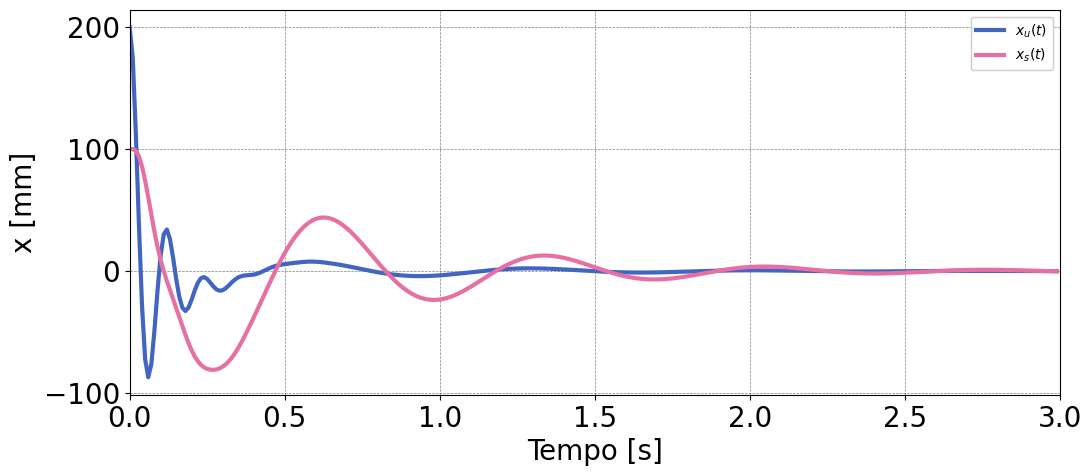

In [9]:
time, y = ct.forced_response(system, T=time, U=(u), X0=np.block([X0.T, V0.T]))

#Plot único:
plt.rcParams['figure.figsize'] = (12, 5)
fig, ax = plt.subplots()
labels = ['$x_u(t)$', '$x_s(t)$']
for i in range(2):
    ax.plot(time, (y[i]*1e3), label=labels[i])
ax.set_ylabel('x [mm]')
ax.set_xlabel('Tempo [s]')
ax.legend(fontsize=10)
plt.xlim(0, tf)
if(title):
    plt.title('Resposta Temporal Real')
plt.savefig('curves/TR2_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')

### Resposta em Frequência: Diagrama de Bode

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


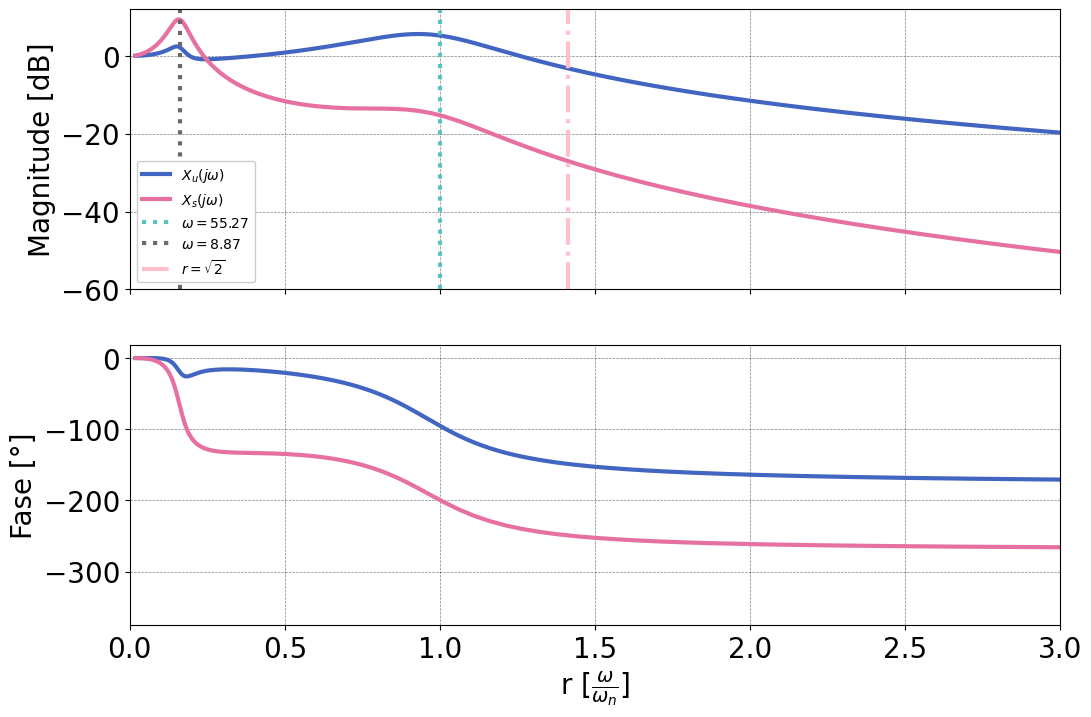

In [8]:
ft = ct.ss2tf(system)
num = ft.num
den = ft.den

bode = []
for i in range(len(omega_n)):
    bode.append(ct.bode(ct.tf(num[i][0], den[i][0]), plot=False))

N = np.max(omega_n)

plt.rcParams['figure.figsize'] = (12, 8)
plt.subplots(2, sharex=True)

labels = ['$X_u(j\omega)$', '$X_s(j\omega)$']
plt.subplot(2, 1, 1)
for i in range(len(omega_n)):
    plt.plot((bode[i][2]/N), mag2db(bode[i][0]), label=labels[i])
for i in range(len(omega_n)):
    plt.plot((omega_n[i]/N, omega_n[i]/N), (-60, 12), linestyle='dotted', label=f'$\omega = {omega_n[i]:.2f}$')
plt.plot((np.sqrt(2), np.sqrt(2)), (-60, 12), color='pink', linestyle='-.', label='$r = \sqrt{2}$')
plt.xlim(0, 3)
plt.ylim(-60, 12)
plt.ylabel('Magnitude [dB]')
plt.legend(fontsize=10)
plt.subplot(2, 1, 2)
for i in range(len(omega_n)):
    plt.plot((bode[i][2]/N), np.degrees(bode[i][1]))
plt.xlim(0, 3)
plt.xlabel('r [$\\frac{\omega}{\omega_n}$]')
plt.ylabel('Fase [°]')
if(title):
    plt.subplot(len(omega_n), 1, 1)
    plt.title('Resposta em Frequência')
plt.savefig('curves/FR_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')